In [1]:
# This is a set of scripts to explore a MVPA analysis with Smith and Wang
# Python 2
# First thing is importing the libraries
import nilearn
from nilearn import datasets,image,masking,signal,plotting,input_data
import numpy as np
import pandas as pd
import sklearn as skl
import os
import matplotlib.pyplot as plt
os.chdir('../')


/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  after removing the cwd from sys.path.
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset impo

In [2]:
#Second thing is getting the data
# Gonna download 2 sets of masks that we may use
sub_cort_HO=datasets.fetch_atlas_harvard_oxford(
    'sub-prob-2mm')
pauli=datasets.fetch_atlas_pauli_2017()
#List of z_images
func_list=[]
label_list=[]
#List of labels
sublist=os.listdir('data')
for sub in sublist:
    print sub
    func_list.append('data/%s/%s_func.nii.gz'%(sub,sub))
    label_list.append(
        pd.read_csv('data/%s/%s_labels.csv'%(sub,sub)
                   ,sep='\t'))
    
for df in label_list:
    df['high_low']=df.apply(lambda row: np.greater(row[3],2.5),axis=1 )

sub-119
sub-118
sub-107
sub-113
sub-106
sub-112
sub-125
sub-123
sub-108
sub-111
sub-115
sub-117
sub-120
sub-116
sub-114
sub-109
sub-121
sub-122
sub-104
sub-110


Here we verify that everything is looking normal for one subject
sub-119
data/sub-119/sub-119_func.nii.gz


,Unnamed: 0,0,1,2,3,type,run,high_low
0,0,1.0,1.0,3.0,0.0,a,1,True
1,1,2.0,1.0,1.0,0.0,a,1,False
2,2,3.0,1.0,2.0,0.0,a,1,False
3,3,4.0,1.0,2.0,0.0,a,1,False
4,4,5.0,1.0,2.0,0.0,a,1,False


 The areas in the pauli 2017 atlas are ['Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr', 'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH']


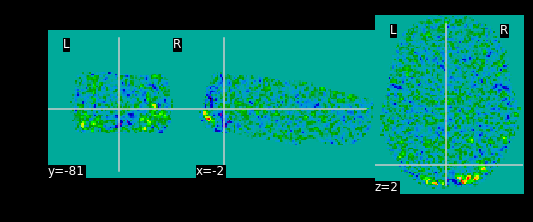

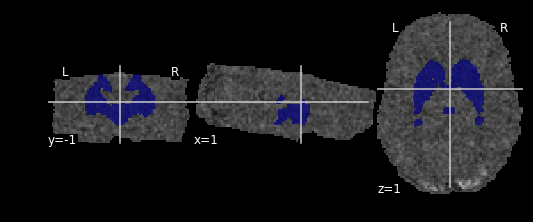

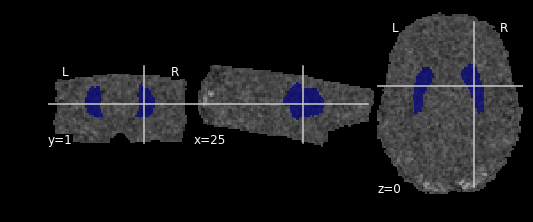

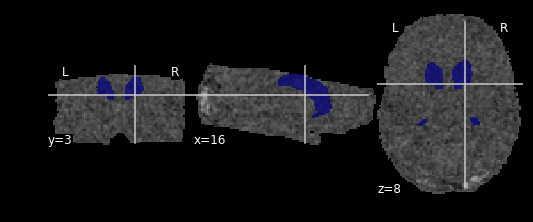

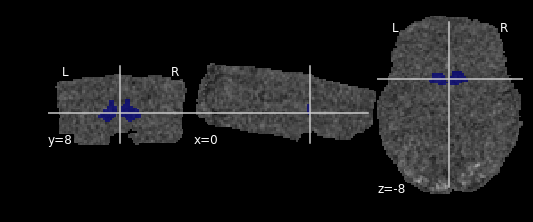

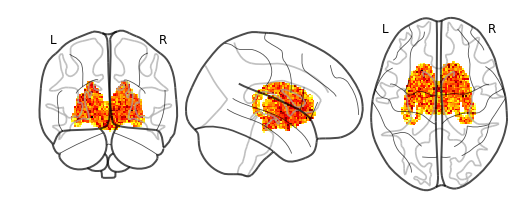

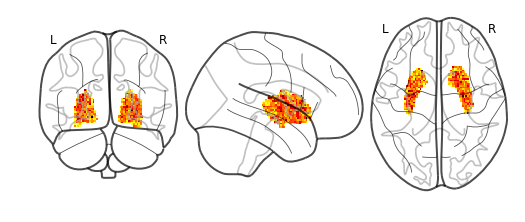

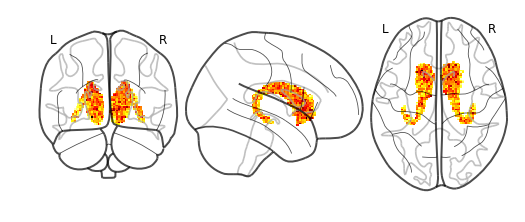

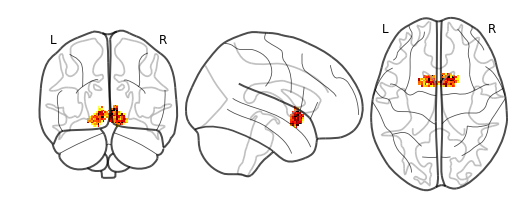

In [3]:
#Let's check out our data and masks
#the behavioral is hopefully easiest to verify
print("Here we verify that everything is looking normal for one subject")
print(sublist[0])
#we can check manually if we want that
#this is correct. It is
print(func_list[0])
display(label_list[0].head())
print(" The areas in the pauli 2017 atlas are %s"%(pauli.labels))
func=image.load_img(func_list[0])
mean_img=image.image.mean_img(func)
plotting.plot_epi(mean_img)
small_mask=masking.compute_background_mask(
    image.resample_to_img(pauli.maps,mean_img,interpolation='linear'))

res_put=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,0),mean_img,interpolation='linear'))

res_caud=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,1),mean_img,interpolation='linear'))

res_Nac=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,2),mean_img,interpolation='linear'))

plotting.plot_roi(small_mask,mean_img)
plotting.plot_roi(res_put,mean_img)
plotting.plot_roi(res_caud,mean_img)
plotting.plot_roi(res_Nac,mean_img)

#make a few different maskers for full subcortex of interest and sub areas
full_pauli_masker=input_data.NiftiMasker(mask_img=small_mask, standardize=False)
Put_masker=input_data.NiftiMasker(mask_img=res_put,standardize=False)
                                            
Caud_masker=input_data.NiftiMasker(mask_img=res_caud,standardize=False)
                                   
NAc_masker=input_data.NiftiMasker(mask_img=res_Nac,standardize=False)

maskers=[full_pauli_masker,Put_masker,Caud_masker,NAc_masker]

#look at all the masked images they make
masked_img=full_pauli_masker.fit_transform(image.index_img(func,1))
Put_masked_img=Put_masker.fit_transform(image.index_img(func,1))
Caud_masked_img=Caud_masker.fit_transform(image.index_img(func,1))
NAc_masked_img=NAc_masker.fit_transform(image.index_img(func,1))

plotting.plot_glass_brain(image.image.mean_img(
        full_pauli_masker.inverse_transform(masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Put_masker.inverse_transform(Put_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Caud_masker.inverse_transform(Caud_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        NAc_masker.inverse_transform(NAc_masked_img)))
plt.show()

from nilearn.input_data import NiftiMasker
from sklearn import preprocessing
import pandas as pd
sub="sub-119"
from sklearn.svm import SVC
svc=SVC(C=0.002,kernel='linear',decision_function_shape='ovo',max_iter=1000,verbose=True)

cols=['sub','mask','train_desc','test_desc','acc','train_test']
my_data=pd.DataFrame(columns=['sub','mask','train_desc','test_desc','acc','train_test'])
data=[]
masker_list=[]
for ii,AOI in enumerate(pauli.labels) :
        print (AOI)
        
        res=masking.compute_background_mask(
            image.resample_to_img(
                image.index_img(
                    pauli.maps,ii),mean_img,interpolation='linear'))
        current_masker=input_data.NiftiMasker(mask_img=res,standardize=True)
        masker_list.append(current_masker)
for i,sub in enumerate(sublist):
    func=image.load_img(func_list[i])
    mean_img=image.image.mean_img(func)
    print sub,func_list[i]
    behavioral = pd.read_csv('data/%s/%s_labels.csv'%(sub,sub),sep='\t')
    func_filename = func_list[i]
    
    behavioral['high_low']=df.apply(lambda row: np.greater(row[3],2.5),axis=1 )
    display(behavioral.head())
    
    
    # For decoding, standardizing is often very important
    for ii,masker in enumerate(masker_list) :
        AOI=pauli.labels[ii]
        print(AOI)
        
        
        current_masker=masker
        X = current_masker.fit_transform(func_filename)
        #normed_X=preprocessing.normalize(X)
        normed_X=preprocessing.normalize(X=X, axis=0)
        #don't run now normed_Xtrain=preprocessing.normalize(X_train)
        #don't run now normed_Xtest=preprocessing.normalize(X_test)
        
        #Training on affective vs informative (run1 vs run2)
        # validating on affective vs informative (run3 vs run4)
        Y_train=behavioral.loc[behavioral['run'].isin([1,2])]
        Y_test=behavioral.loc[behavioral['run'].isin([3,4])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.type)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.type==Y_predicts])
        acc=np.mean([Y_test.type==Y_predicts])
        
        data.append([sub,AOI,"A_I r1_r2","A_I r3_r4",acc,"a/i_a/i"])
        #Training on high vs low aff run...
        # validating on high vs low inf run ...
        Y_train=behavioral.loc[behavioral['type'].isin(['a'])]
        Y_test=behavioral.loc[behavioral['type'].isin(['i'])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.high_low)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.high_low==Y_predicts])
        acc=np.mean([Y_test.high_low==Y_predicts])
        
        data.append([sub,AOI,"H_L Aff_runs","H_L Inf_runs",acc,"a(h/l)_i(h/l)"])
        #Training on high vs low aff run...
        # validating on high vs low inf run ...
        Y_train=behavioral.loc[behavioral['type'].isin(['i'])]
        Y_test=behavioral.loc[behavioral['type'].isin(['a'])]
        
        X_train=normed_X[Y_train.index]
        X_test=normed_X[Y_test.index]
              
        svc.fit(X=X_train,y=Y_train.high_low)
        Y_predicts=svc.predict(X_test)
        print np.mean([Y_test.high_low==Y_predicts])
        acc=np.mean([Y_test.high_low==Y_predicts])
        
        data.append([sub,AOI,"H_L inf_runs","H_L Aff",acc,"i(h/l)_a(h/l)"])
    


data_filename='Acc_data.csv'

my_data=pd.DataFrame(data,columns=cols)

my_data.to_csv(data_filename)
   
    
    
    

sub-119 data/sub-119/sub-119_func.nii.gz
0.9875


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

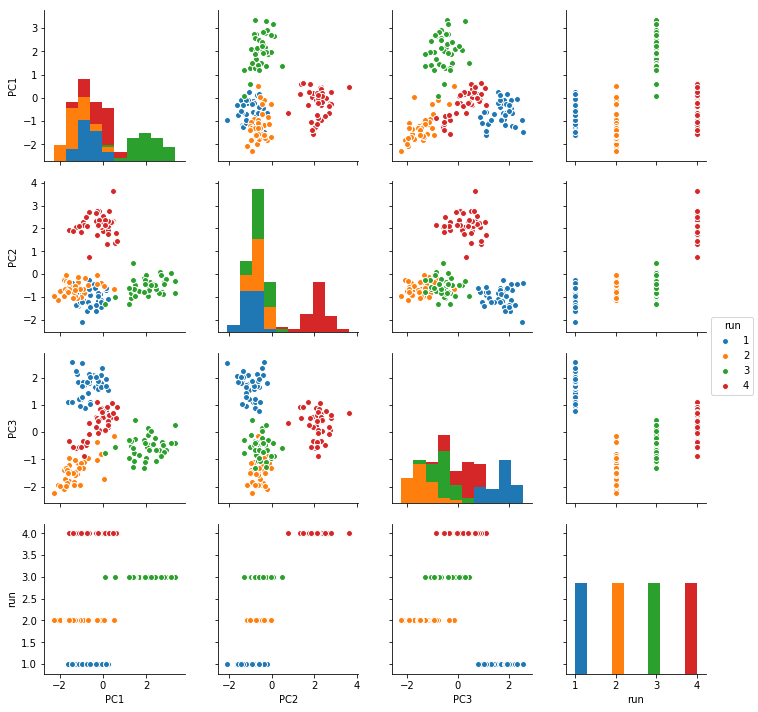

sub-118 data/sub-118/sub-118_func.nii.gz
0.925


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

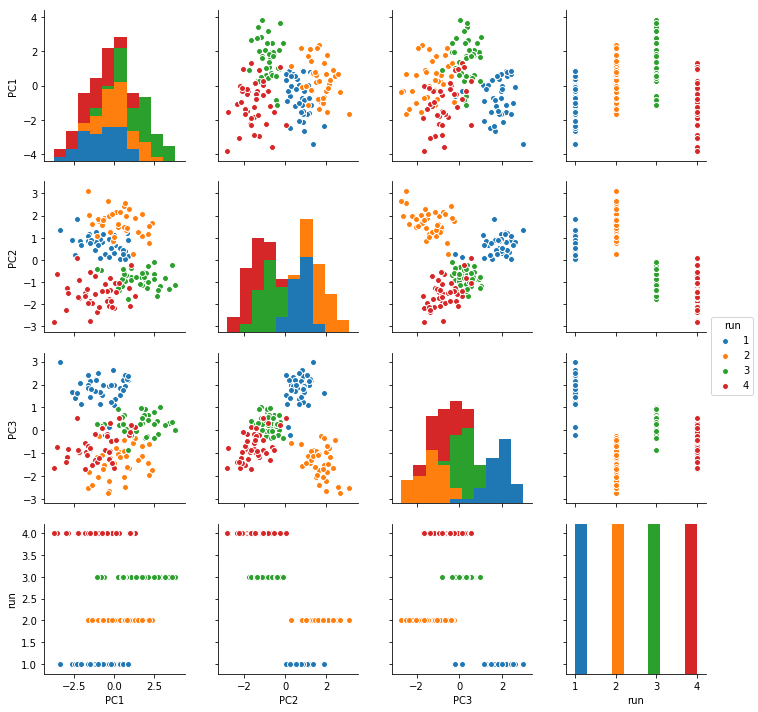

sub-107 data/sub-107/sub-107_func.nii.gz
0.66875


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

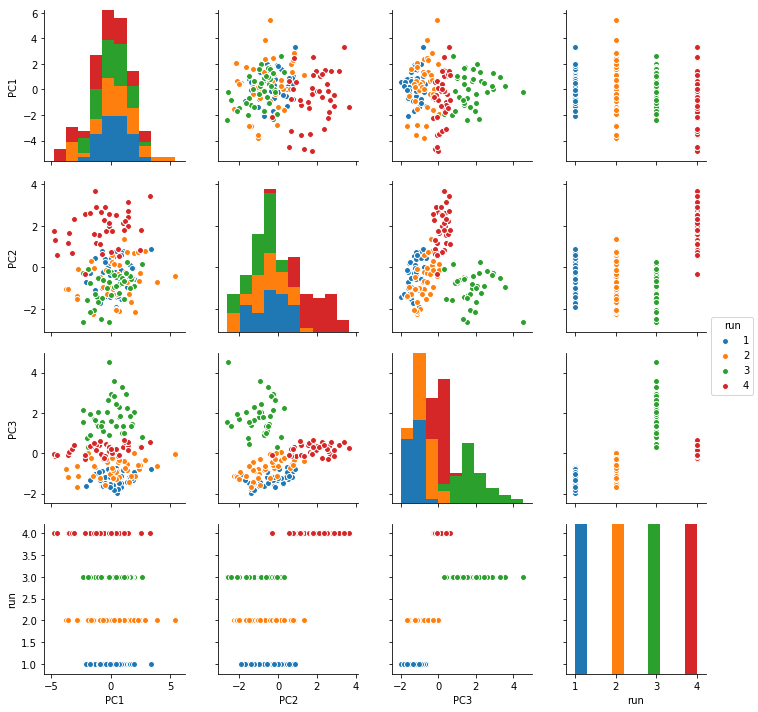

sub-113 data/sub-113/sub-113_func.nii.gz
0.8875


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

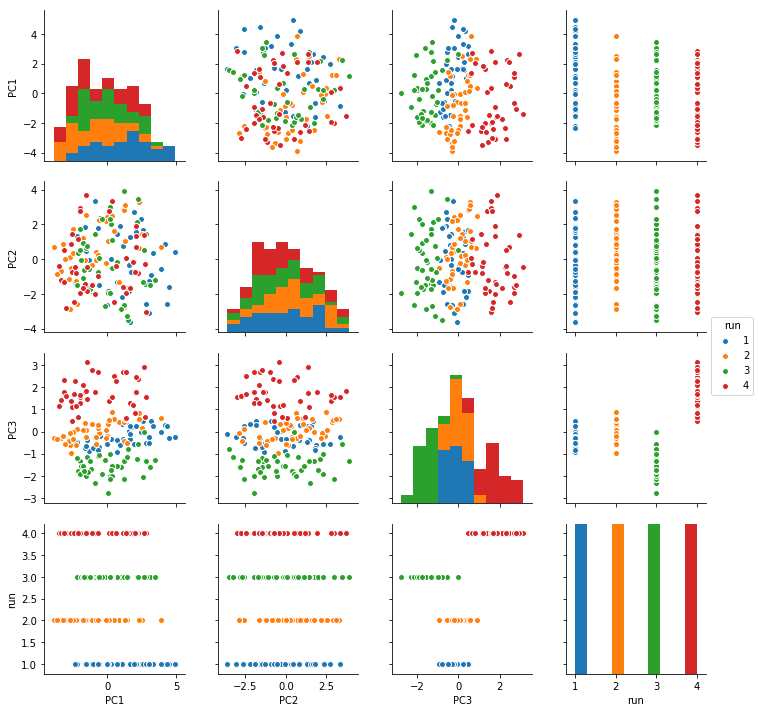

sub-106 data/sub-106/sub-106_func.nii.gz
0.85


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

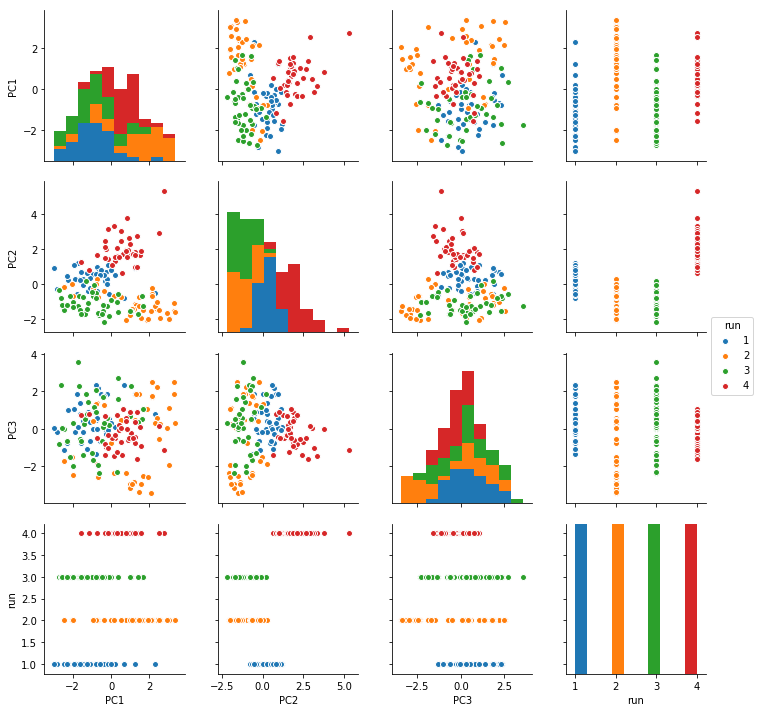

sub-112 data/sub-112/sub-112_func.nii.gz
0.975


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

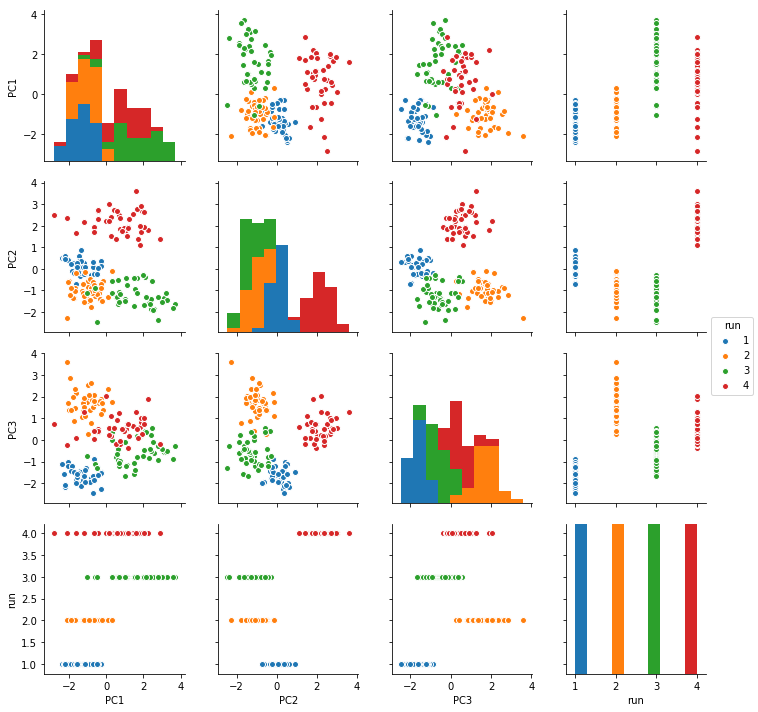

sub-125 data/sub-125/sub-125_func.nii.gz
0.89375


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

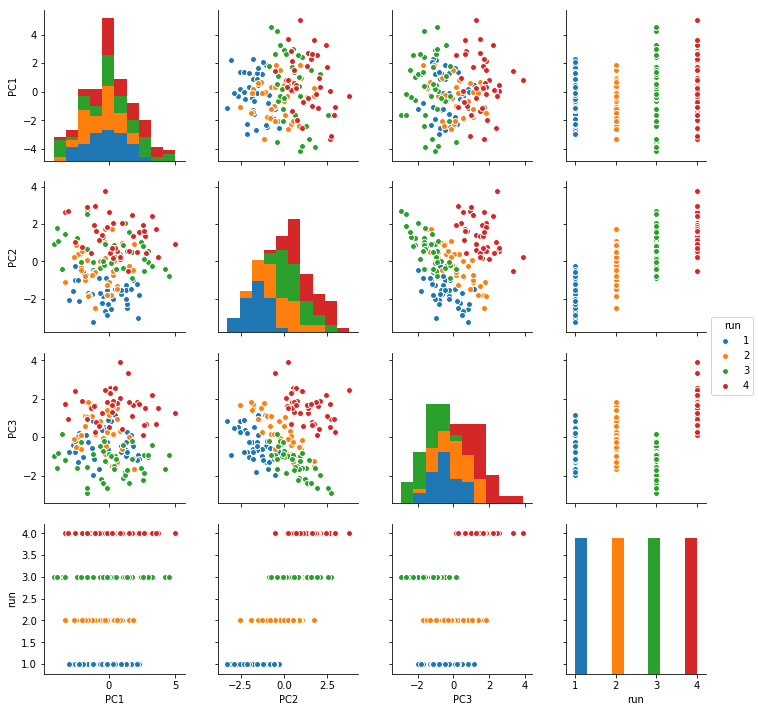

sub-123 data/sub-123/sub-123_func.nii.gz
0.5875


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

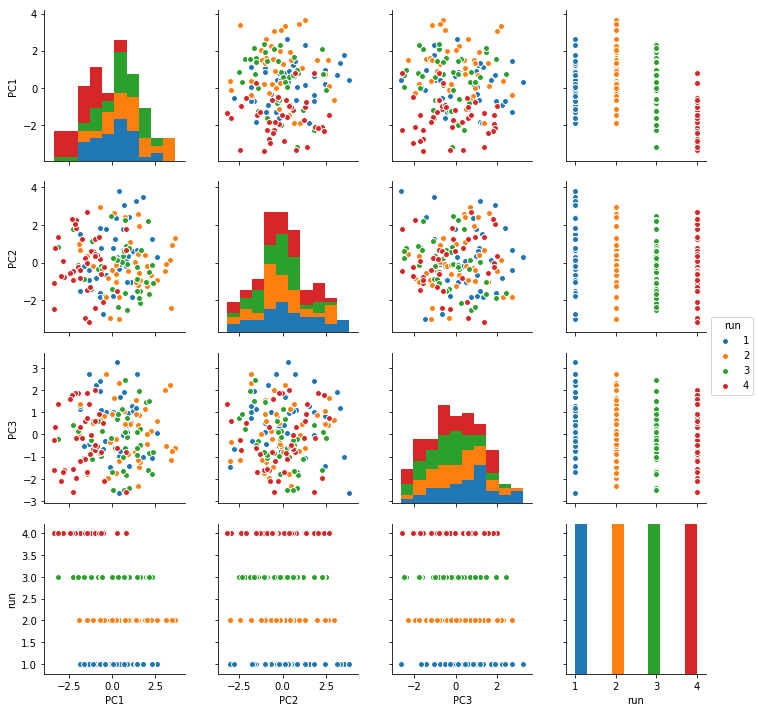

sub-108 data/sub-108/sub-108_func.nii.gz
0.7125


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

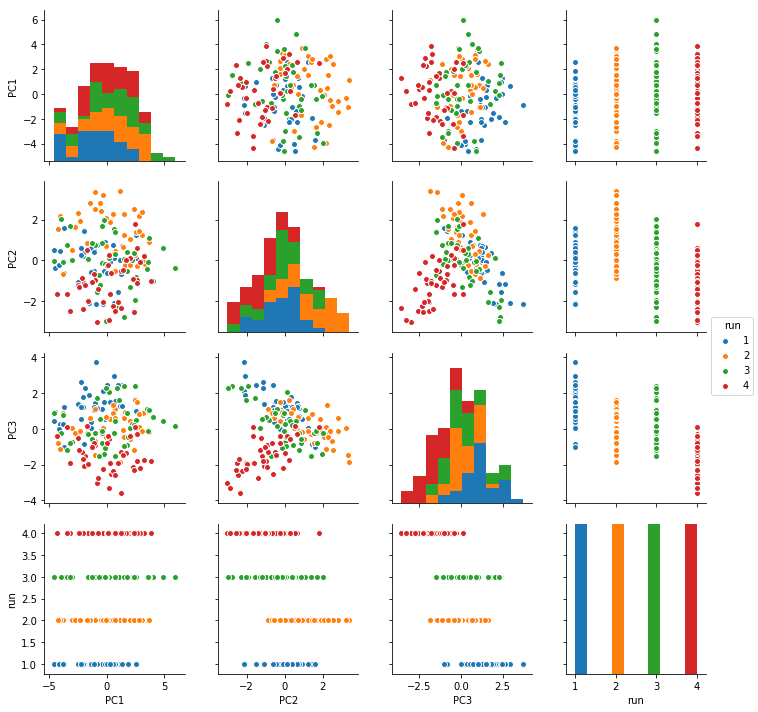

sub-111 data/sub-111/sub-111_func.nii.gz
1.0


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

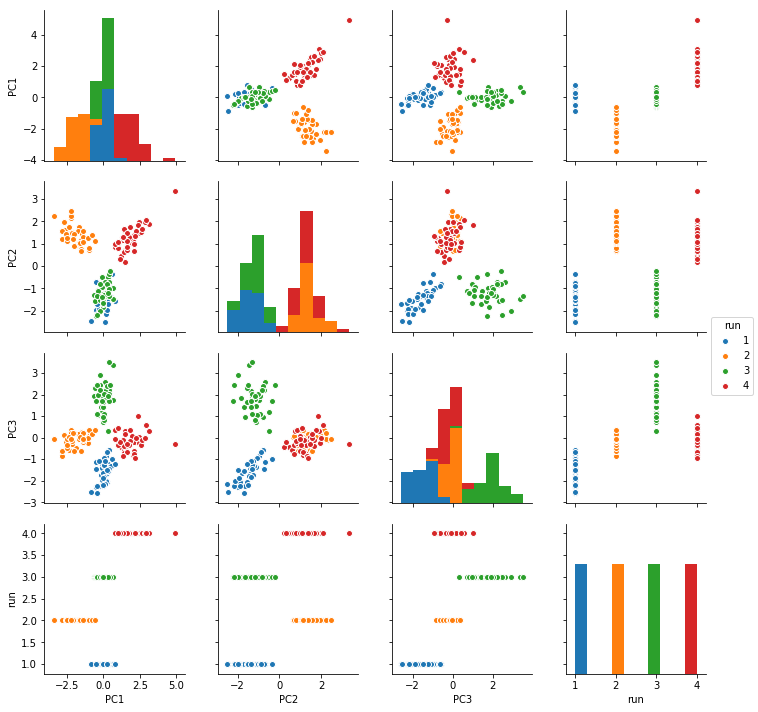

sub-115 data/sub-115/sub-115_func.nii.gz
0.73125


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

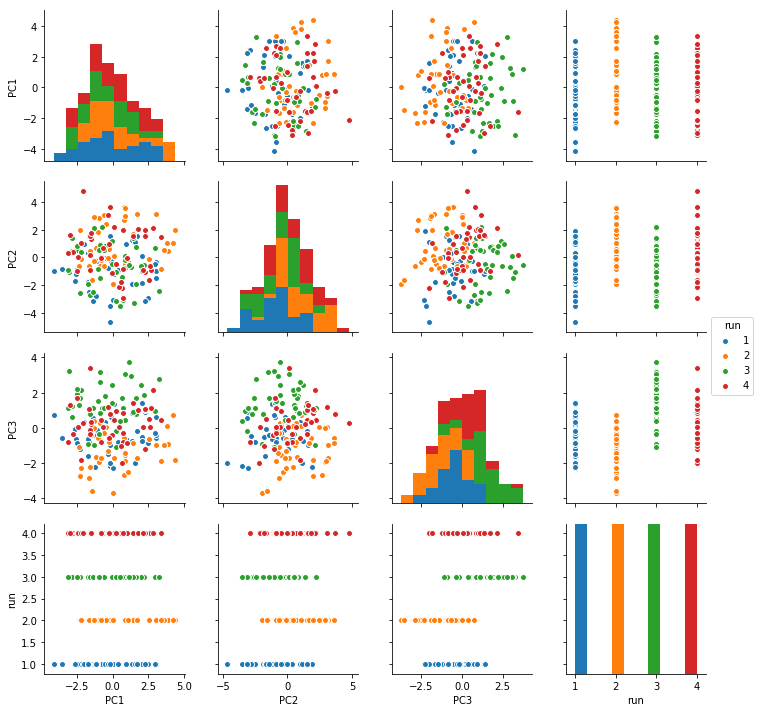

sub-117 data/sub-117/sub-117_func.nii.gz
0.775


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

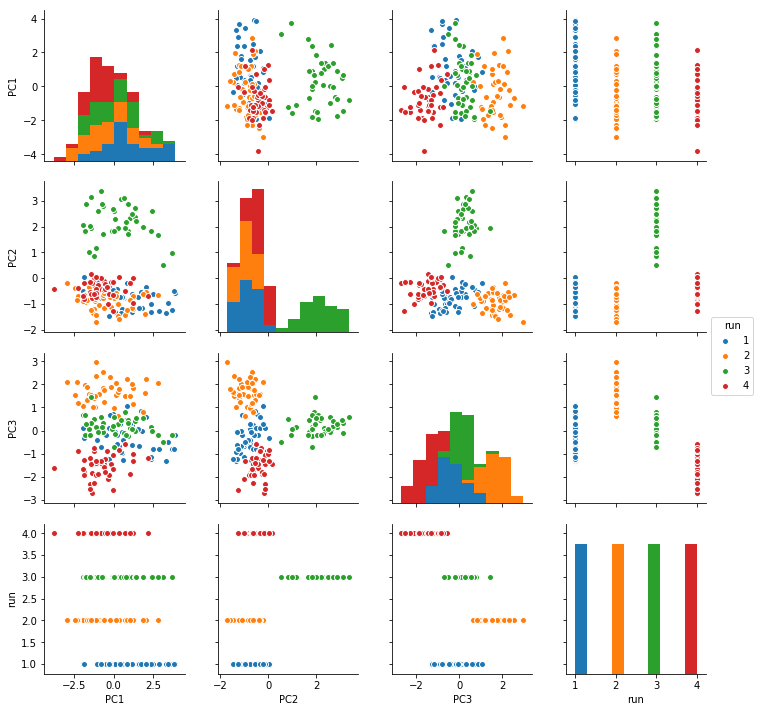

sub-120 data/sub-120/sub-120_func.nii.gz
0.95


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

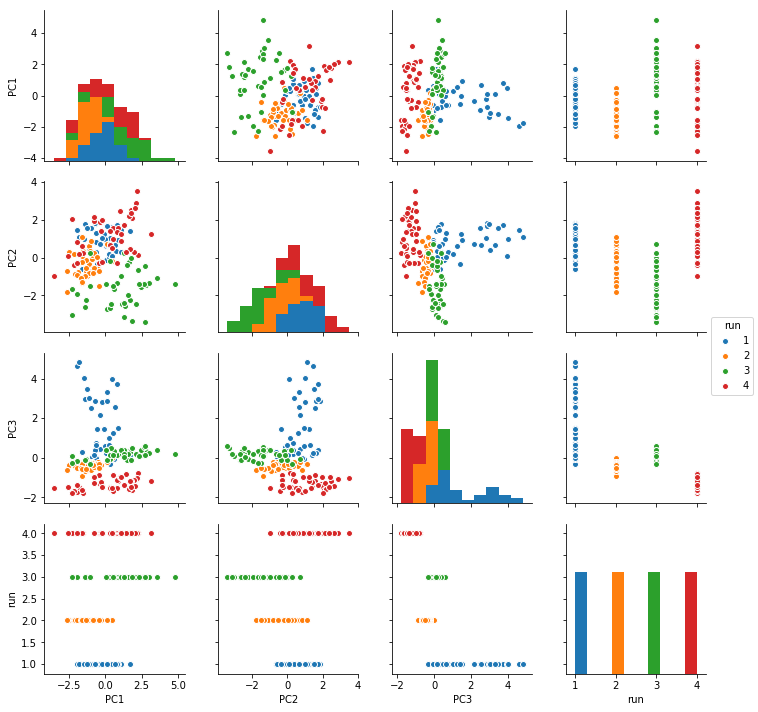

sub-116 data/sub-116/sub-116_func.nii.gz
0.84375


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

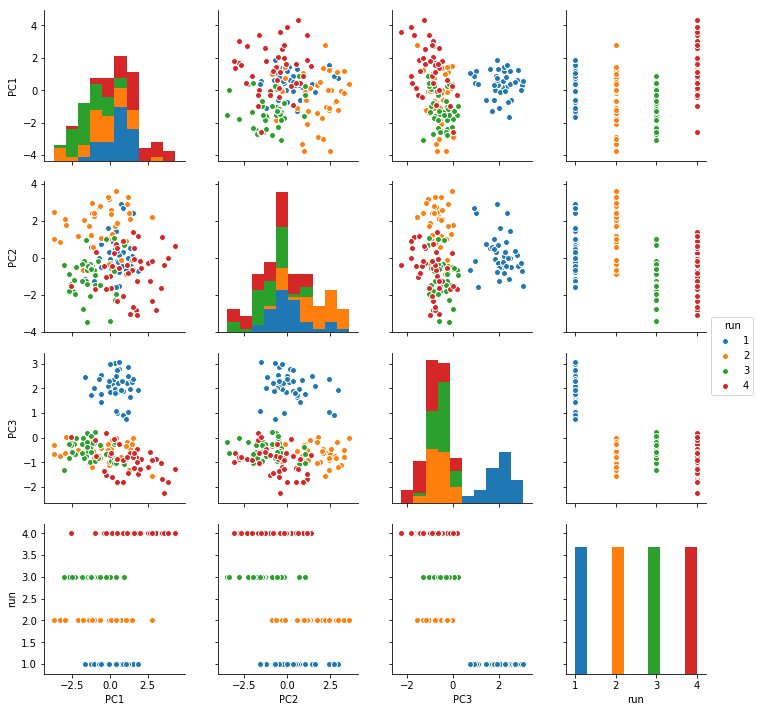

sub-114 data/sub-114/sub-114_func.nii.gz
0.94375


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

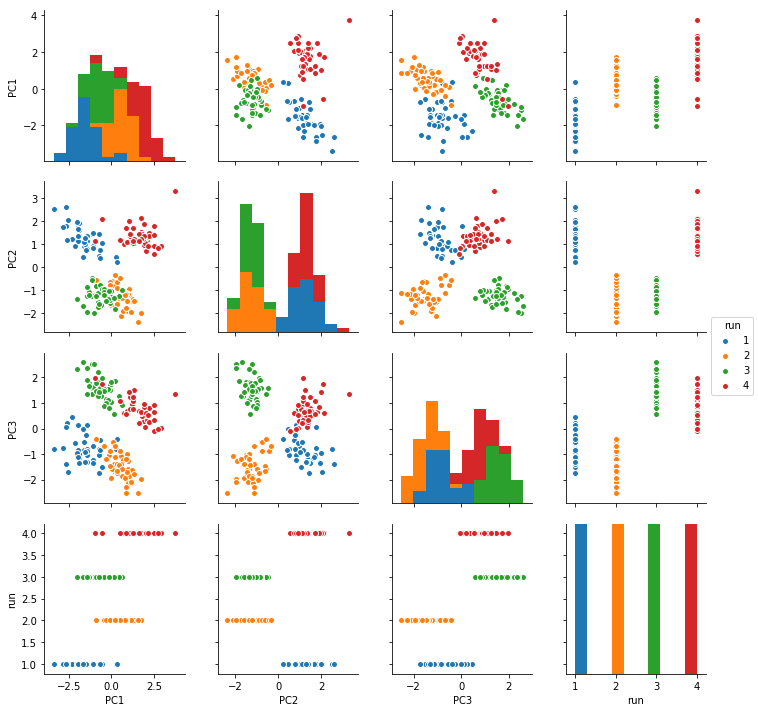

sub-109 data/sub-109/sub-109_func.nii.gz
0.80625


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

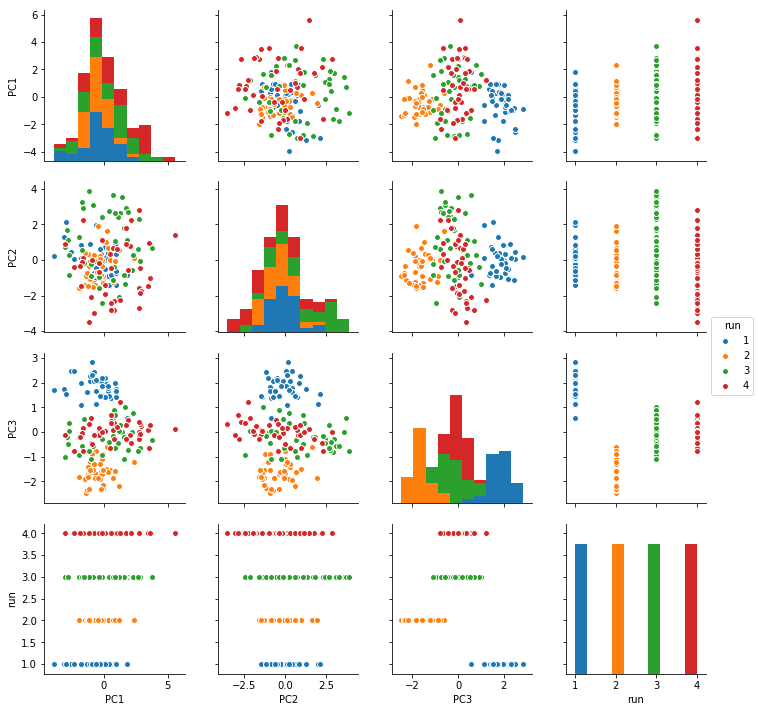

sub-121 data/sub-121/sub-121_func.nii.gz
0.56875


run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

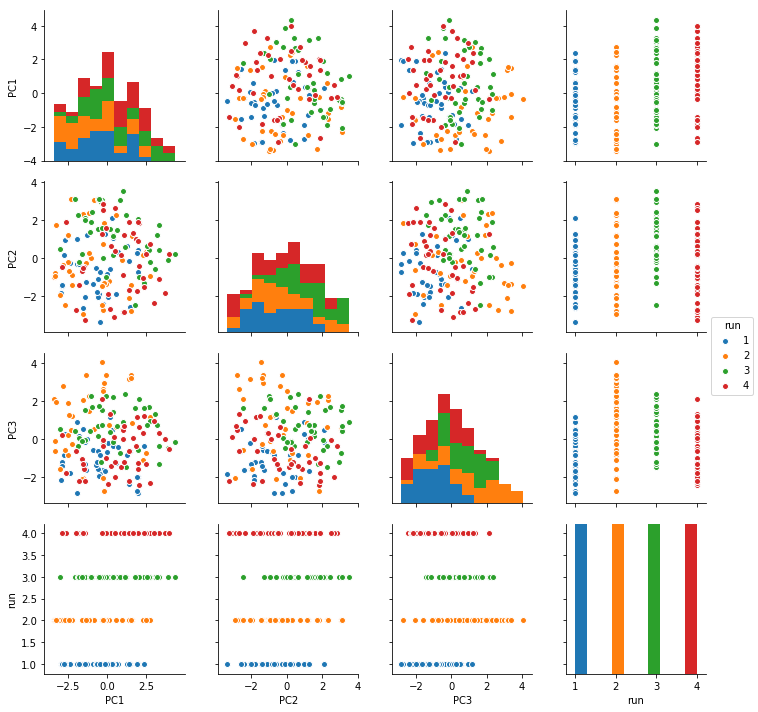

sub-122 data/sub-122/sub-122_func.nii.gz
0.825


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

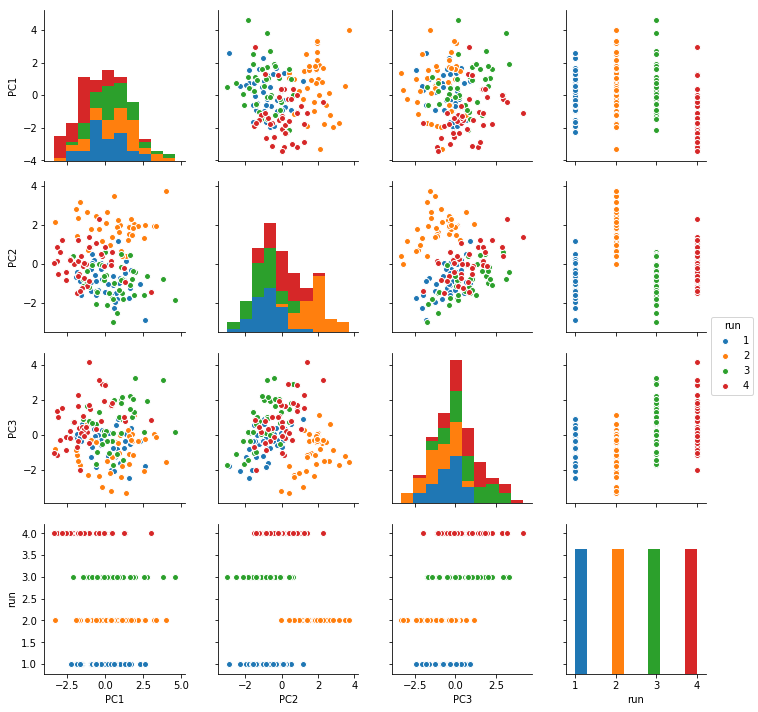

sub-104 data/sub-104/sub-104_func.nii.gz
1.0


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

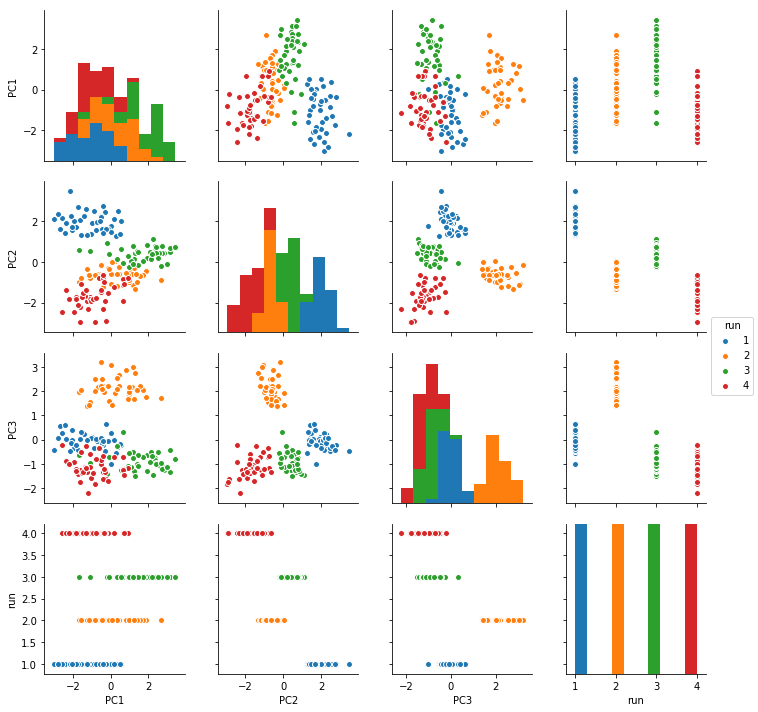

sub-110 data/sub-110/sub-110_func.nii.gz
0.6875


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

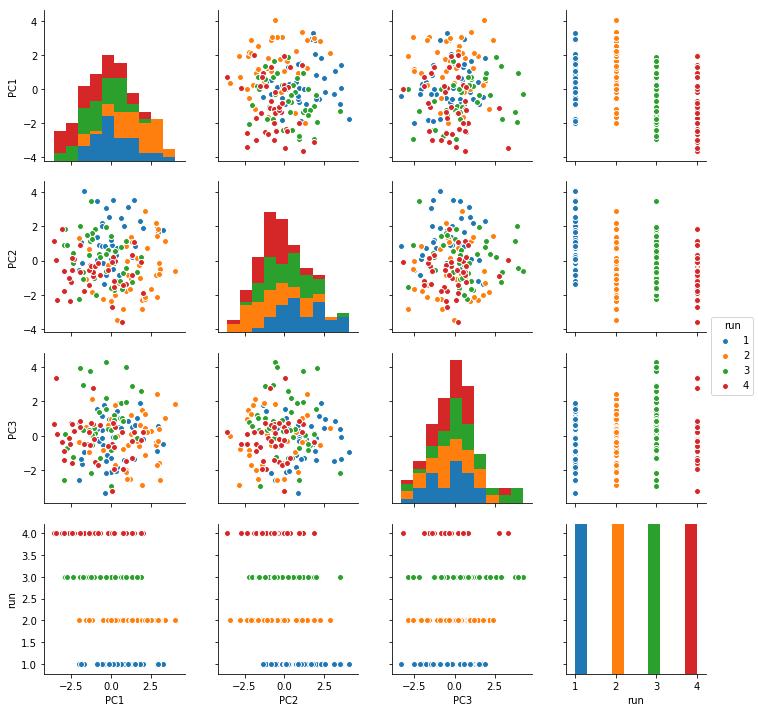

In [8]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, LeaveOneOut
import seaborn as sns

loo=LeaveOneOut()
pca=PCA(n_components=3)
cols=['sub','AOI','train_desc','test_desc','acc','train_test','train_acc']
data=[]
masker=full_pauli_masker
svc=sklearn.svm.SVC(C=1.0,
                    kernel='linear',verbose=False)

for i,sub in enumerate(sublist):
    AOI="total_striatum"
    func=image.load_img(func_list[i])
    mean_img=image.image.mean_img(func)
    print sub,func_list[i]
    behavioral = pd.read_csv('data/%s/%s_labels.csv'%(sub,sub),sep='\t')
    func_filename = func_list[i]
    
    behavioral['high_low']=df.apply(lambda row: np.greater(row[3],2.5),axis=1 )
    #display(behavioral.head())
    
    
    current_masker=masker
    X = current_masker.fit_transform(func_filename)
    X=sklearn.preprocessing.normalize(X)
    X=sklearn.preprocessing.normalize(X=X, axis=0)
    X=pca.fit_transform(X)
    #don't run now normed_Xtrain=preprocessing.normalize(X_train)
    #don't run now normed_Xtest=preprocessing.normalize(X_test)        
    #Training on affective vs informative (run1 vs run2)
    # validating on affective vs informative (run3 vs run4)
    scores=cross_val_score(svc,X=X,y=behavioral.type,cv=loo)
    print np.mean(scores)
    data=pd.DataFrame({'PC1':X[:,0],'PC2':X[:,1],'PC3':X[:,2],'run':behavioral.run,'type':behavioral.type})
    display(data.groupby(by='run').type.unique())
    sns.pairplot(data=data,hue='run')
    plt.show()

    


   
    
    
    

In [ ]:
type(X)

In [ ]:
import seaborn as sns

data_filename='Acc_data.csv'

my_data=pd.read_csv(data_filename,index_col=0)
display(my_data.head())

df_ai=my_data.loc[my_data["train_test"]=="a/i_a/i"]

f=sns.barplot(x="train_test",y="acc",data=my_data)
plt.gcf().set_size_inches(10.5,5.5)
plt.axhline(y=0.5,color='k',linestyle='-')
plt.show()
f=sns.barplot(x="AOI",y="acc",data=my_data)
plt.axhline(y=0.5,color='r',linestyle='-')


plt.show()


In [ ]:
tt=my_data.train_test.unique()
print(tt[2])
df_ai=my_data.loc[my_data["train_test"]==tt[2]]

f=sns.barplot(x="mask",y="acc",data=df_ai)
plt.gcf().set_size_inches(10.5,5.5)
plt.axhline(y=0.5,color='k',linestyle='-')
plt.show()
f=sns.boxplot(x="mask",y="acc",data=df_ai)
plt.axhline(y=0.5,color='r',linestyle='-')


plt.show()

In [ ]:
pauli.description